import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
df = yf.download('ADVANC.BK',start = '2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [42]:
def RSI(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    df['RSI'] = rsi
    print('RSI indicators added')

In [43]:
RSI(df)

RSI indicators added


def MACD(df):
    df['EMA12'] = df.Close.ewm(span=12).mean()
    df['EMA26'] = df.Close.ewm(span=26).mean()
    df['MACD'] = df.EMA12 - df.EMA26
    df['signal'] = df.MACD.ewm(span=9).mean()
    print('MACD indicators added')

MACD(df)

In [44]:
def Adx(df,lookback=14):
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(df['High'] - df['Low'])
    tr2 = pd.DataFrame(abs(df['High'] - df['Close'].shift(1)))
    tr3 = pd.DataFrame(abs(df['Low'] - df['Close'].shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    df['Adx'] = adx_smooth
    print('ADX indicators added')

In [45]:
Adx(df)

ADX indicators added


In [411]:
def Stoch(df,lookback=50):
    #Create the "L14" column in the DataFrame
    df['L'] = df['Low'].rolling(lookback).min()
    #Create the "H14" column in the DataFrame
    df['H'] = df['High'].rolling(lookback).max()
    #Create the "%K" column in the DataFrame
    df['Sto_K'] = 100*((df['Close'] - df['L']) / (df['H'] - df['L']) )
    #Create the "%D" column in the DataFrame
    df['Sto_D'] = df['Sto_K'].rolling(window=3).mean()
    print('Stoch indicators added')

In [412]:
Stoch(df)

Stoch indicators added


In [413]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI,Adx,L,H,Sto_K,Sto_D
Date,,,,,,,,,,,,
2021-08-23,183.5,184.0,180.0,181.0,181.0,10197200,55.278829,21.072035,169.0,186.5,68.571429,76.190476
2021-08-24,181.5,183.0,180.5,181.0,181.0,5456900,55.278829,20.284683,169.0,186.5,68.571429,73.333333
2021-08-25,181.0,184.0,180.5,183.5,183.5,7122600,60.242077,19.577835,169.0,186.5,82.857143,73.333333
2021-08-26,183.5,185.0,182.0,184.0,184.0,9407000,61.170257,19.260342,169.0,186.5,85.714286,79.047619
2021-08-27,183.5,185.5,183.0,184.5,184.5,9635000,62.122557,19.281539,169.0,186.5,88.571429,85.714286


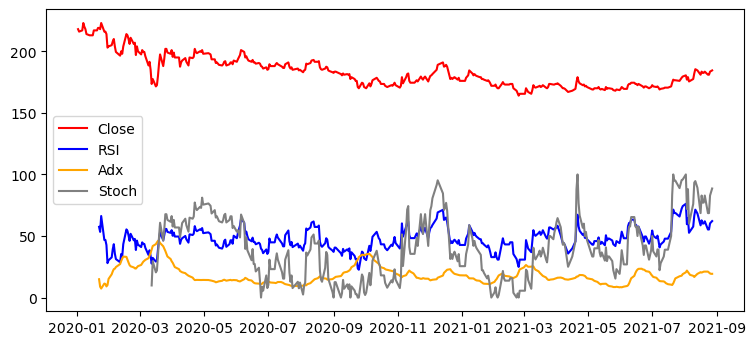

In [414]:
plt.figure(figsize=(9,4), dpi = 100)
plt.plot(df.Close,label = 'Close', color = 'red')
plt.plot(df.RSI,label ='RSI',color='blue')
plt.plot(df.Adx,label = 'Adx',color = 'orange')
plt.plot(df.Sto_K,label ='Stoch', color = 'grey')
plt.legend()
plt.show()

In [558]:

Buy_RSI, Sell_RSI = [],[]
Buy_Adx, Sell_Adx = [],[]
Buy_Sto, Sell_Sto = [],[]
Buy,Sell = [],[]

for i in range(2,len(df)):        
    if df.RSI.iloc[i] > 60:
        Buy_RSI.append(i)
    elif df.RSI.iloc[i] < 50:
        Sell.append(i)
    if df.RSI.iloc[i] > 71:
        Sell.append(i)
    if df.RSI.iloc[i] < 25:
        Buy_RSI.append(i)
for i in range(2,len(df)):
    if df.Adx.iloc[i] > df.Adx.iloc[i-1] and df.Adx.iloc[i] > df.Adx.iloc[i-2]:
        Buy_Adx.append(i)
for i in range(2,len(df)):
    if df.Sto_D.iloc[i] >80:
        Buy_Sto.append(i)
    elif df.Sto_D.iloc[i] <60:
        Sell.append(i)


In [559]:
def check_buy_signal(a,b,c):
    list1=list(set(a) & set(b))
    result=list(set(list1)&set(c))
    return sorted(result)

In [560]:
check_buy_signal([1,2],[1,2,3],[1,3])

[1]

In [561]:
def check_buy_signal2(buy,sell):
    ans=list()
    for bd in sell:
        ad = bd
        while True:
            ad+=1
            if ad == min(buy):
                ans.append(ad)
            if ad > max(buy):
                break
            if ad in buy:
                ans.append(ad)
                break
    return list(dict.fromkeys(sorted(ans)))


In [562]:
def check_sell_signal(buy,sell):
    ans=list()
    for bd in buy:
        ad = bd
        while True:
            ad+=1
            if ad > max(sell):
                break
            if ad in sell:
                ans.append(ad)
                break
    return list(dict.fromkeys(sorted(ans)))


In [563]:
Buy = check_buy_signal(Buy_Adx,Buy_Sto,Buy_RSI)

In [564]:
Buy

[228, 229, 230, 231, 376, 377, 378, 379, 380, 381, 389]

In [565]:
Sell

[17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 56,
 65,
 66,
 67,
 68,
 69,
 71,
 72,
 73,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 129,
 130,
 131,
 132,
 133,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 207,
 212,
 213,
 214,
 223,
 230,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 

In [566]:
Buy = check_buy_signal2(Buy,Sell)

In [567]:
Sell = check_sell_signal(Buy,Sell)

In [568]:
Buy

[228, 231, 376, 380, 381, 389]

In [569]:
Sell

[230, 235, 379, 381, 388]

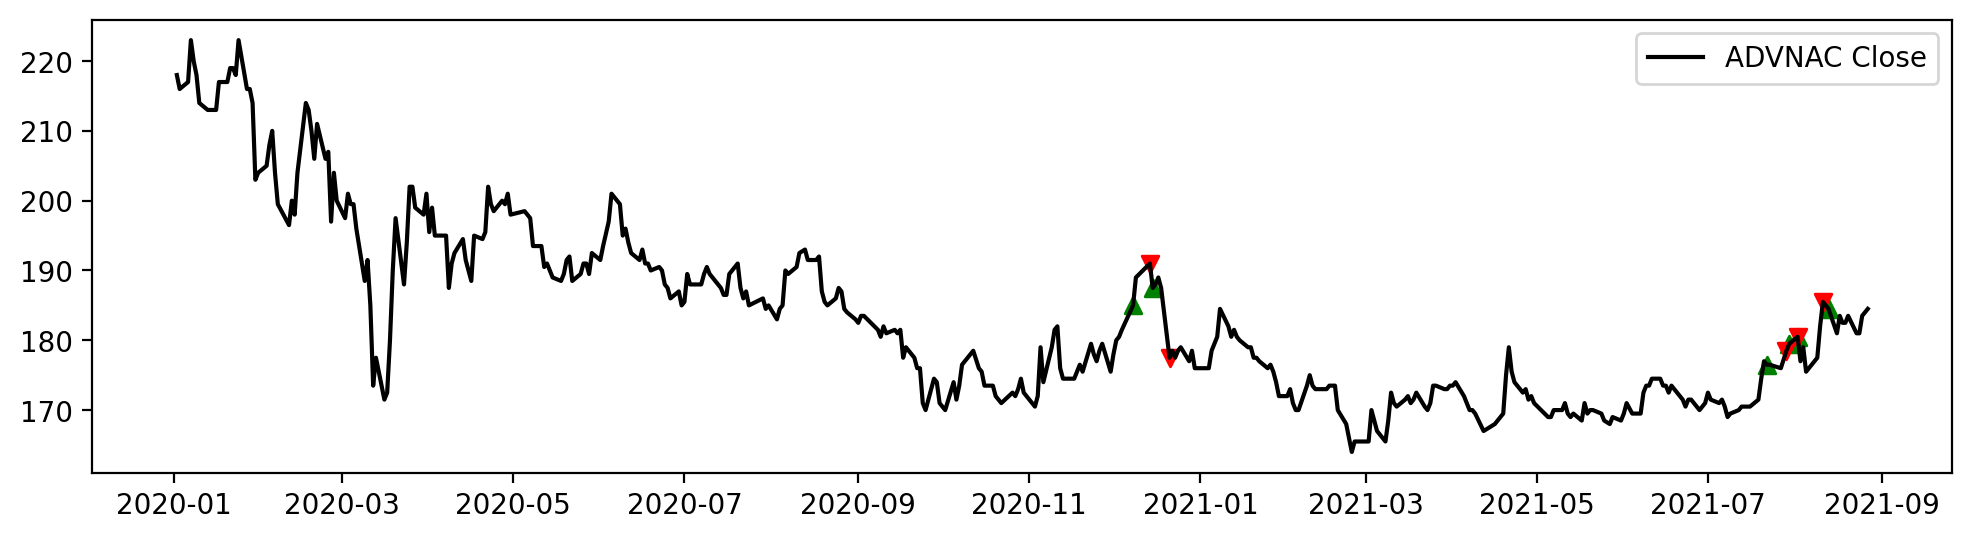

In [570]:
plt.figure(figsize=(12, 3),dpi=200)
plt.scatter(df.iloc[Buy].index,df.iloc[Buy].Close,marker="^",color='green')
plt.scatter(df.iloc[Sell].index,df.iloc[Sell].Close,marker="v",color='red')
plt.plot(df.Close, label='ADVNAC Close',color='k')
plt.legend()
plt.show()

In [571]:
Realbuys = [i+1 for i in Buy]
Realsells = [i+1 for i in Sell]

In [572]:
Realbuys

[229, 232, 377, 381, 382, 390]

In [573]:
Sell

[230, 235, 379, 381, 388]

In [574]:
Realsells

[231, 236, 380, 382, 389]

In [575]:
Buyprices = df.Open.iloc[Realbuys]
Sellprices = df.Open.iloc[Realsells]

In [576]:
if Sellprices.index[0] < Buyprices.index[0]:
    Sellprices = Sellprices.drop(Sellprices.index[0])
elif Buyprices.index[-1] > Sellprices.index[-1]:
    Buyprices = Buyprices.drop(Buyprices.index[-1])

In [577]:
Buyprices

Date
2020-12-09    188.0
2020-12-16    189.0
2021-07-23    176.0
2021-08-02    179.5
2021-08-03    180.0
Name: Open, dtype: float64

In [578]:
Sellprices

Date
2020-12-15    189.5
2020-12-22    178.5
2021-07-30    178.0
2021-08-03    180.0
2021-08-13    185.5
Name: Open, dtype: float64

In [579]:
profit = []

for i in range(len(Sellprices)):
    profit.append((Sellprices[i]-Buyprices[i])/Buyprices[i])

In [580]:
profit

[0.007978723404255319,
 -0.05555555555555555,
 0.011363636363636364,
 0.002785515320334262,
 0.030555555555555555]

sum(profit)/len(profit)

In [581]:
pd.DataFrame(profit).mean()

0   -0.000574
dtype: float64